<a href="https://colab.research.google.com/github/kamalova/Applied-Machine-Learning-Explainability-Techniques/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string
string.punctuation
import re
from sklearn.feature_extraction.text import TfidfVectorizer


# Data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn's beautiful styling
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from wordcloud.wordcloud import STOPWORDS


In [2]:
%rm -rf sample_data/

In [3]:

reviews_march = pd.read_csv('/content/reviews_march.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_jun = pd.read_csv('/content/reviews_jun.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_sep = pd.read_csv('/content/reviews_sep.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_dec = pd.read_csv('/content/reviews_dec21.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);

In [4]:
print(reviews_march.shape, reviews_jun.shape, reviews_sep.shape, reviews_dec.shape)
      

(20000, 6) (20000, 6) (20000, 6) (20000, 6)


In [74]:
# Concatinate Reviews from each quarter
df_reviews = pd.concat([reviews_march,reviews_jun, reviews_sep,reviews_dec])

In [ ]:

df_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>"
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.\r<br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!"
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!"
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!
...,...,...,...,...,...,...
19995,72265,161050979,2017-06-16,109542482,John,Vanessa was very pleasant and communication was very good.
19996,72265,163401732,2017-06-24,1282541,Sofia,Great location! Close to G train.
19997,72265,252657179,2018-04-11,8936723,Yo,"Highly recommend. Cannot beat this value. <br/><br/>Great location - 4 minute walk to subway and 20 sec to bus which connects you easily and quickly to various parts of Manhattan and Brooklyn. Organic (as well as regular) grocery stores and lots of awesome restaurants and stores near by. Very safe neighborhoods <br/>Nice room - not big but it's plenty enough and everything works well. It's nice & warm in the winter. Even though the bedroom is separated by a curtain to the kitchen, because the host is mainly in the other section of the apartment, you have a lot of privacy. <br/>Vanessa is a very friendly, interesting and helpful host."
19998,72265,277084426,2018-06-15,17160406,Ioannis,"Vanessa is a great and very polite host and gives you as much privacy as you want. The room can be seen in the photos and has everything you need. The location is amazing as well with plenty of bars, restaurants and stores around and literally half a block away from G train."


In [6]:
df_reviews = df_reviews.drop(columns=['id','reviewer_name'])


In [7]:
df_reviews.isnull().sum()

listing_id     0
date           0
reviewer_id    0
comments       6
dtype: int64

In [75]:
# #separating date column into day month and year
df_reviews['year'],df_reviews['month'],df_reviews['days'] = df_reviews['date'].str.split('-',2).str
df_reviews.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,days
0,2595,17857,2009-11-21,50679,Jean,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>",2009,11,21
1,2595,19176,2009-12-05,53267,Cate,Great experience.,2009,12,05
2,2595,19760,2009-12-10,38960,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.\r<br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!",2009,12,10
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!",2010,04,09
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!,2010,05,25


In [76]:
df_reviews['date'] = pd.to_datetime(df_reviews.date)
df_reviews['weekday'] = df_reviews['date'].dt.day_name()

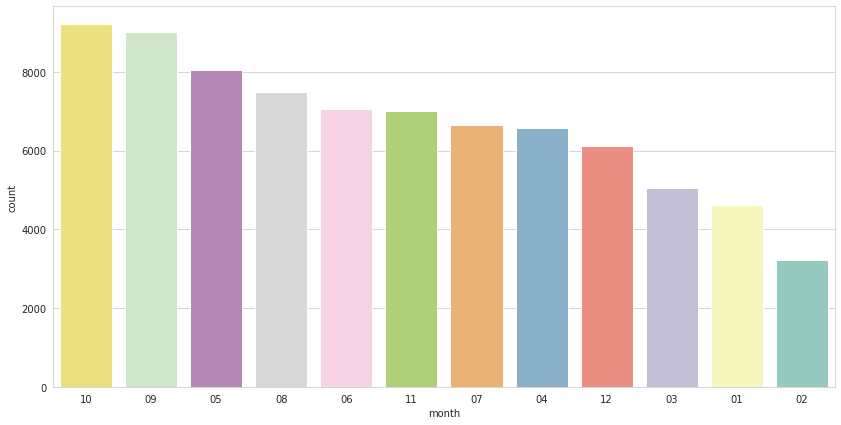

In [10]:
plt.figure(figsize=(14,7))
ax = sns.countplot(x='month', data=df_reviews, order=df_reviews['month'].value_counts().index, palette='Set3_r')

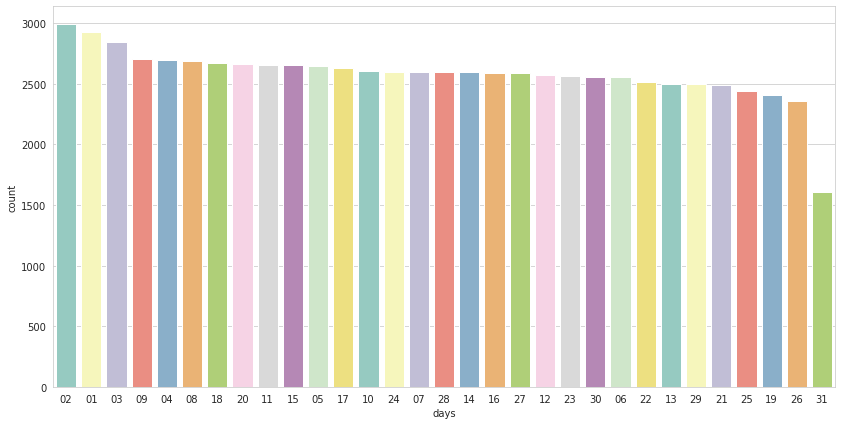

In [11]:
plt.figure(figsize=(14,7))
ax = sns.countplot(x='days', data=df_reviews, order=df_reviews['days'].value_counts().index,  palette='Set3')

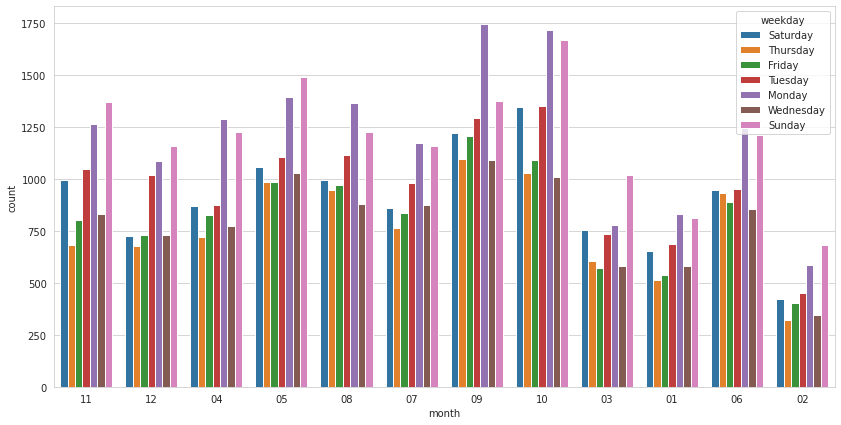

In [ ]:
plt.figure(figsize=(14,7))
ax = sns.countplot(x='month', data=df_reviews, hue='weekday')

In [ ]:
df_reviews['reviewer_id'].nunique()


28943

There are 28943 different ID for reviews in this data.

In [ ]:
df_reviews.columns

Index(['listing_id', 'date', 'reviewer_id', 'comments', 'year', 'month',
       'days', 'weekday'],
      dtype='object')

In [77]:
df_reviews.drop(columns=['date','year','days'], inplace=True)

#### Preprocessing *Comments* for Sentiment Analysis

In [78]:
df_reviews.dropna(subset =['comments'],how='any',axis=0,inplace=True)

In [14]:
! pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 14.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cd05f1e474e8d1b83b43bfc53952812c47349359ec0a96f6f48e63ba9cab8613
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [15]:
# Import language detect
from langdetect import detect

In [82]:
# Detect the language of the comments
def detect_lang(x):
    try:
        lang = detect(x)
    except:
        lang = 'other'
    return lang

df_reviews['language'] = df_reviews['comments'].apply(detect_lang)

In [83]:
# Preview frist 5 rows of dataframe
df_reviews

,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language
0,2595,17857,50679,Jean,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>",11,Saturday,fr
1,2595,19176,53267,Cate,Great experience.,12,Saturday,ro
2,2595,19760,38960,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.\r<br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!",12,Thursday,en
3,2595,34320,71130,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!",04,Friday,en
4,2595,46312,117113,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!,05,Tuesday,en
...,...,...,...,...,...,...,...,...
19995,72265,161050979,109542482,John,Vanessa was very pleasant and communication was very good.,06,Friday,en
19996,72265,163401732,1282541,Sofia,Great location! Close to G train.,06,Saturday,en
19997,72265,252657179,8936723,Yo,"Highly recommend. Cannot beat this value. <br/><br/>Great location - 4 minute walk to subway and 20 sec to bus which connects you easily and quickly to various parts of Manhattan and Brooklyn. Organic (as well as regular) grocery stores and lots of awesome restaurants and stores near by. Very safe neighborhoods <br/>Nice room - not big but it's plenty enough and everything works well. It's nice & warm in the winter. Even though the bedroom is separated by a curtain to the kitchen, because the host is mainly in the other section of the apartment, you have a lot of privacy. <br/>Vanessa is a very friendly, interesting and helpful host.",04,Wednesday,en
19998,72265,277084426,17160406,Ioannis,"Vanessa is a great and very polite host and gives you as much privacy as you want. The room can be seen in the photos and has everything you need. The location is amazing as well with plenty of bars, restaurants and stores around and literally half a block away from G train.",06,Friday,en


In [18]:
# Count total language of all dataframe
df_reviews.language.value_counts()

en       71630
fr        3059
es        2071
de        1009
it         498
pt         316
nl         254
zh-cn      150
ja         141
ko         108
other       90
ro          83
sv          82
ru          80
af          51
no          51
da          47
so          40
ca          34
zh-tw       29
pl          26
tl          24
fi          23
cs          20
cy          18
id          11
sw          10
tr           9
hu           8
he           6
el           5
th           3
hr           3
bg           2
et           1
sl           1
vi           1
Name: language, dtype: int64

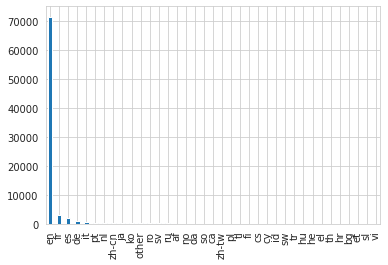

In [19]:
# Plot language column
df_reviews['language'].value_counts().plot.bar();


In [20]:
# Sample of French language
df_reviews.loc[df_reviews['language']=='fr']

,listing_id,reviewer_id,comments,month,weekday,language
0,2595,50679,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>",11,Saturday,fr
123,5178,118953,"chambre tres bien située, du bruit mais c'est normal on est en plein Manhatan. Le propriétaire est tres discret je vous le recommande tres bonne adresse",08,Wednesday,fr
149,5178,311594,"Première fois à New York et très bon séjour ! L'appartement de Shun est vraiment bien situé, à proximité de tout et la chambre est plutôt grande et confonrtable. De plus le métro est à côté donc c'est également très pratique pour aller dans les lieux à visiter qui n'étaient pas proche. Times Square et Central park à côté ! Et enfin Shun est vraiment très gentil et discret. Il était là si nous avions des questions. Encore merci à lui pour ce très bon séjour, nous recommandons cet hébergement, si nous devons retourner à New York nous choisirons encore son appartement !",03,Tuesday,fr
200,5178,1337014,"Nous avons séjourné une semaine chez Shun. Grande chambre très propre et bien équipée (frigo, micro-onde, bureau, ordinateur et wifi, étagère, grand placard...).\r<br/>Shun a été très attentif à ce que nous manquions de rien tout en étant très discret. Nous l'avons très peu vu car nous rentrions souvent tard. Nous recommandons cette chambre.",04,Monday,fr
229,5178,3768630,"La chambre était confortable bien que dépouillé de toutes décorations, surtout l'emplacement est idéal, proche des stations de métro et de broadway. \r<br/>Shun est un hote discret mais disponible",01,Saturday,fr
...,...,...,...,...,...,...
19636,68974,71309926,"Idéalement placé, au carrefour de Soho, Little Italie, Chinatown. Boutiques pour les filles, resto pour le soir et à 100 mètres du métro!<br/>Logement très agréable, bien équipé ( cuisine, ordinateur a dispo etc....) et bien chauffé dans lequel on se sent bien. Pas particulièrement bruyant car au 4eme étage (et je suis de la campagne donc je suis sensible au bruit).<br/>Alicia très arrangeante quant aux horaires d'arrivée (22h) et de départ(19h), très réactive par sms ou mails si on a des questions.<br/>Nous étions 7 (2 couples avec enfants) et avons été, grands et petits, super contents de retrouver notre loft le soir après une journée de visites.<br/>Très agréable, pas seulement un endroit pour dormir. On y a passé de bonnes soirées et les enfants ont pu dormir tard le matin sans être réveillé par le bruit.<br/>Ce qu'il faut savoir: <br/>1) 4 étages d'escalier à monter. Personnellement, je ne suis pas sportive mais ça ne m'a pas posé de problème. <br/>2) 1 seul salle de bain donc il faut s'organiser quand on est 7<br/>Merci Alicia. J'y reviendrais!<br/>",01,Monday,fr
19661,68974,28711110,Super appartement dans un quartier animé et central. La décoration est sympa. La cuisine très bien équipée. Salon cosy. Bien chauffé en hiver. Très recommandable.,12,Tuesday,fr
19675,68974,190923463,"Nous avons adoré ce loft! Nous étions une famille de 5 et c’était idéal pour notre séjour de 6 jours, bien situé pour explorer à pied le sud de Manhattan (puis en métro depuis Grand Street a 2 pas du loft, pour le centre et nord). L’appart est tres propre, bien aménagé et organisé, très bien climatisé, confortable et très spacieux! Exercices cardio gratuits en prime pour monter 4 ( dernier) étages tous les jours ( 

In [ ]:
df_reviews.loc[df_reviews['language']=='sl']

,listing_id,date,reviewer_id,comments,language
6458,105790,2014-11-24,10169217,"Privet vsem! Ya po russki. Arman ochen' gostepriimniy, obchitel'niy chozyain. Raspologenye kvartiri horoshee, Komnata super. Eche poedu obyazatel'no ostanovlus' u Armana.\r<br/>",sl
13841,56859,2017-05-14,116271063,"Skvělá lokalita+bezpecna, blizkost obchodu, metro do centra 5 min., dobra komunikace s hostitelem, koupelna sdilena s hostitelem primerene cista, pokoj studenejsi s hlukem z ulice. (Spatne uzavreni okna)",sl


In [ ]:
df_reviews.loc[df_reviews['language']=='et']

,listing_id,date,reviewer_id,comments,language


In [ ]:
df_reviews.loc[df_reviews['language']=='pl']

,listing_id,date,reviewer_id,comments,language
1129,6990,2009-10-31,7691,nice,pl
7910,27644,2014-06-27,15813035,"Emma była bardzo miły gospodarz. Spędziliśmy wspaniały czas w Nowym Jorku.Apartament znajduje się w bardzo wygodnym miejscu. W pobliżu stacji metra. Jest duży, czysty i dobrze wyposażone, ale meble są dość stare.\r<br/>Krzysztof",pl
11590,45542,2018-09-11,214030038,nice guy nice place,pl
11848,45556,2019-11-29,131269496,Very nice!,pl
12450,53469,2013-08-15,7462716,"Bezpieczna, spokojna i cicha okolica. Sprawna komunikacja z kartą MTA autobus i metro. Wygodna łazienka i ogarnięta otwarta kuchnia. Gospodarz bardzo pomocny i otwarty.",pl
19235,74680,2014-06-19,9845175,Super miejsce. Gorąco polecam,pl
1134,45542,2018-09-11,214030038,nice guy nice place,pl
1730,45556,2019-11-29,131269496,Very nice!,pl
3495,89621,2017-09-17,143337753,Was nice,pl
3496,89621,2017-09-21,150733803,"Pokój bardzo czysty i przyjemny. Właściciele bardzo mili, nie było problemu z moim późniejszym przyjazdem. Lokalizacja bardzo wygodna, blisko do komunikacji miejskiej. Jak najbardziej mogę polecić to miejsce :)",pl


In [84]:
# Filter out only english comments
df_reviews = df_reviews.loc[(df_reviews['language'] == 'en')] 

In [85]:
# Count total english comments
df_reviews.language.value_counts()

en    71636
Name: language, dtype: int64

In [86]:
# Preprocessing Comments
def clean_text(text):
    '''
    input- 'text' to be preprocessed
    output- converts input 'text' to lowercase,remove square brackets,links,punctuation 
    and words containing numbers. Removes common accent characters and returns clean text. 
    '''
    text = text.lower()
    text = re.sub('<br\s?\/>|<br>',"", text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # removes punctuations
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    return text

In [87]:
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: clean_text(x))
df_reviews.head()

,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language
2,2595,19760,38960,Anita,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,12,Thursday,en
3,2595,34320,71130,Kai-Uwe,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,04,Friday,en
4,2595,46312,117113,Alicia,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,05,Tuesday,en
5,2595,1238204,1783688,Sergey,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,05,Monday,en
6,2595,1293632,1870771,Loïc,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,05,Thursday,en


In [88]:
# Create a function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# Remove emojis from  the comments
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: remove_emoji(x))

In [89]:
# Reset Index
df_reviews.reset_index(inplace=True, drop=True)

In [90]:
# Calculate the lenghth of the comments
df_reviews['text_length'] = df_reviews['comments'].apply(lambda x : len(x))
df_reviews.head(4)


,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language,text_length
0,2595,19760,38960,Anita,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,12,Thursday,en,468
1,2595,34320,71130,Kai-Uwe,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,04,Friday,en,366
2,2595,46312,117113,Alicia,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,05,Tuesday,en,155
3,2595,1238204,1783688,Sergey,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,05,Monday,en,570


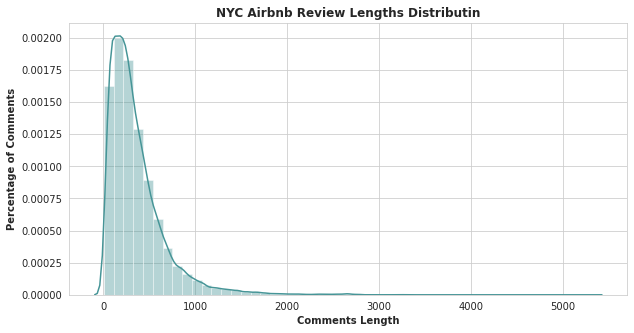

In [25]:
# Plot distribution of the comment length
plt.figure(figsize=(10, 5))
sns.distplot(df_reviews.text_length, kde=True, bins=50, color='#469597')
plt.title('NYC Airbnb Review Lengths Distributin', fontweight="bold")
plt.xlabel('Comments Length', fontweight="bold")
plt.ylabel('Percentage of Comments', fontweight="bold");

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df_reviews.shape

(71648, 6)

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71648 entries, 0 to 71647
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   71648 non-null  int64 
 1   date         71648 non-null  object
 2   reviewer_id  71648 non-null  int64 
 3   comments     71648 non-null  object
 4   language     71648 non-null  object
 5   text_length  71648 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.3+ MB


In [ ]:
df_reviews

,listing_id,date,reviewer_id,comments,language,text_length
0,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en,468
1,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en,366
2,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en,155
3,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en,570
4,2595,2012-05-17,1870771,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,en,204
...,...,...,...,...,...,...
71636,72265,2017-06-16,109542482,vanessa was very pleasant and communication was very good,en,58
71637,72265,2017-06-24,1282541,great location close to g train,en,34
71638,72265,2018-04-11,8936723,highly recommend cannot beat this value great location minute walk to subway and sec to bus which connects you easily and quickly to various parts of manhattan and brooklyn organic as well as regular grocery stores and lots of awesome restaurants and stores near by very safe neighborhoods nice room not big but it s plenty enough and everything works well it s nice warm in the winter even though the bedroom is separated by a curtain to the kitchen because the host is mainly in the other section of the apartment you have a lot of privacy vanessa is a very friendly interesting and helpful host,en,626
71639,72265,2018-06-15,17160406,vanessa is a great and very polite host and gives you as much privacy as you want the room can be seen in the photos and has everything you need the location is amazing as well with plenty of bars restaurants and stores around and literally half a block away from g train,en,275


In [27]:
# Tfidfvectorizer computes word counts, idf and tf-idf values all at once
# Compute IDF values (Inverse Document Frequency), weight assigned to each word depending on how commonly used
vectorizer = TfidfVectorizer(min_df=53, max_features=50, stop_words='english', ngram_range=(1,2), use_idf=True)
matrix = vectorizer.fit_transform(df_reviews['comments'])


In [29]:
df_reviews['comments'][0]

'Great host '

In [30]:
df_reviews['comments'][0]

'Great host '

In [31]:
# Display first vector, IDF values for first comment
pd.DataFrame(matrix[0].T.todense(), index=vectorizer.get_feature_names(), 
             columns=["tfidf"]).sort_values(['tfidf'], ascending=False).style.bar(subset=['tfidf'], color=['#5fba7d'])

,tfidf
just,0.431949
perfect,0.402302
time,0.393531
lovely,0.244261
new york,0.241695
york,0.241684
staying,0.233586
like,0.233292
new,0.227994
really,0.200927


### Estimate polarity

**ADER (Valence Aware Dictionary and sentiment Reasoner) Sentiment Analysis**:

It is a lexical database and rule-based sentiment analysis tool that is optimized for social media sentiments. It makes use of a variety of techniques. A sentiment lexicon is a collection of lexical features (e.g., words) that are classified as positive or negative depending on their sentiment polarity. It not only exhibits the Positivity and Negativity scores, but also the degree to which a sentiment is positive or negative <p>

The polarity score() method returns a float for the sentiment strength based on the input text

In [32]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [93]:
# Instantiate SentimentAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [94]:
# Test SentimentAnalyzer on first comment
def sentiment_analyzer(comment):
    polarity_score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(polarity_score, orient='index'))

sentiment_analyzer(df_reviews['comments'][0])

,0
neg,0.0000
neu,0.8060
pos,0.1940
compound,0.9274


In [95]:
# Take 'compound' score of the sentiments score
compound_polarity= lambda s: (analyzer.polarity_scores(s))['compound']

In [96]:
# Get compound polarity score of all comments
df_reviews['polarity_score'] = df_reviews.comments.map(compound_polarity)

In [43]:
df_reviews[:5].style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,reviewer_id,comments,month,weekday,language,text_length,polarity_score
2,2595,38960,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York. Attention: it's on the 4th floor without a lift :-) but definetely worth it!",12,Thursday,en,475,0.924800
3,2595,71130,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!",04,Friday,en,366,0.922900
4,2595,117113,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!,05,Tuesday,en,155,0.946400
5,2595,1783688,"Hi to everyone! Would say our greatest compliments to Jennifer, the host of Midtown Castle. We spent in this lovely apartment in the heart of Manhattan one month (April, 2012) and will remember this time as ours best. The apartment is pretty spacious and great located - the 5-th Ave right around the corner. There is everything you can need during your short or long stay. Jennifer is very friendly, vigorous and very responsible host. Thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling Midtown!",05,Monday,en,583,0.986900
6,2595,1870771,"Jennifer was very friendly and helpful, and her place is exactly as advertised. The location is very convenient, and it was a pleasure to stay at the Midtown Castle. I definitely recommend it :) Thanks !",05,Thursday,en,214,0.956800


In [46]:
df_reviews[df_reviews['polarity_score']<0][10:15].style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,reviewer_id,comments,month,weekday,language,text_length,polarity_score
297,5178,4337113,This place is horrible and not what is represented in the photos. Not to mention very dirty. I had a horrible experience!,10,Friday,en,121,-0.888100
323,5178,14767392,He is very quiet but gave no idea about the area The room was a bit small and the walls and windows are dirty as was the microwave. We could not use the kitchen sink as it was blocked . Good location Dave,05,Friday,en,216,-0.665200
342,5178,6154791,"Our apartment building in Philadelphia caught fire, and much of our possessions were ruined and the whole building rendered uninhabitable by water damage the day before I had planned to stay with Shunichi. So I feel asleep within an hour after arriving at his apartment and didn't wake up until the next morning. Which goes to show that the room faces a quiet street and that the bed is comfortable, even if a metal frame. The room is as it looks in the photo, with the additions of a table cloth, cups, mugs and a small mirror, without the plant, stool and dark full length curtain, now replaced by a shorter one that lets the light through it. Shunichi was very communicative about my move in and had no problem with me coming earlier than I initially indicated,nor with me leaving my luggage at his place until I left the city the following day. Then I crashed out.",08,Wednesday,en,875,-0.851900
437,5178,133592606,The apartment was in a great location! It was four blocks from time square! We found a really cool burger place to eat at! The air conditioner was the disappointing part of it all. We got there before the sun went down and had to leave because it was just that hot in the room. No fan was available. It was hot in the city and very uncomfortable to sleep. This was my first airbnb experience.,06,Wednesday,en,392,-0.312900
529,5178,11934009,"the bathroom is dirty, the kitchen could not be used because it was full and dirty, the photos correspond but really very messy everything I would not recommend this place is not the complete apt just a room and bathroom shared",06,Monday,en,227,-0.763000


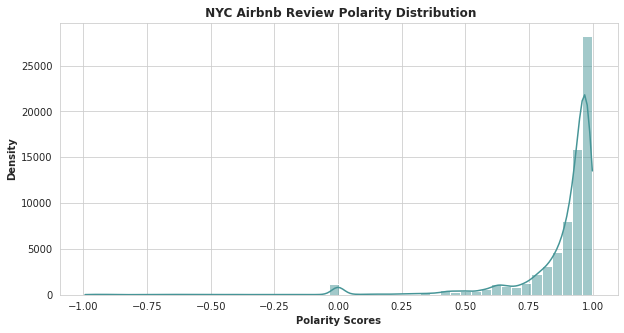

In [48]:
# Plot distribution of the comment length
plt.figure(figsize=(10, 5))
sns.histplot(df_reviews['polarity_score'], kde=True, bins=50, color='#469597')
plt.title(' NYC Airbnb Review Polarity Distribution', fontweight="bold")
plt.xlabel('Polarity Scores', fontweight="bold")
plt.ylabel('Density', fontweight="bold");

Positive    69674
Neutral      1254
Negative      708
Name: sentiment_type, dtype: int64
------------------------------------------


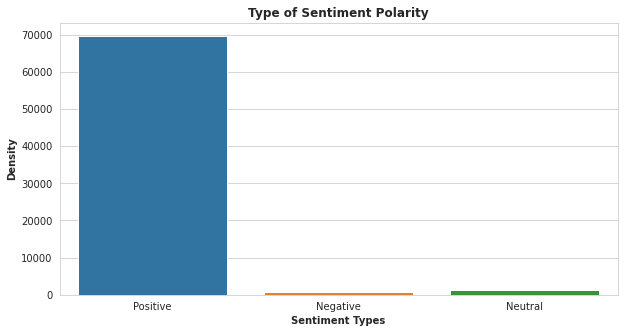

In [97]:
# Decide sentiment as positive, negative and neutral;

def sentiment_type(df_reviews):
    if df_reviews['polarity_score'] >= 0.05:
        val = "Positive"
    elif df_reviews['polarity_score'] <= - 0.05:
        val = "Negative"
    else:
        val = "Neutral"
    return val

df_reviews['sentiment_type'] = df_reviews.apply(sentiment_type, axis=1)

print(df_reviews.sentiment_type.value_counts())
print('------------------------------------------')
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="sentiment_type", data=df_reviews)
plt.title('Type of Sentiment Polarity', fontweight="bold")
plt.xlabel('Sentiment Types', fontweight="bold")
plt.ylabel('Density', fontweight="bold");

In [53]:
df_reviews[df_reviews['sentiment_type']=='Neutral'][:10].style.bar(subset=['polarity_score'],align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,reviewer_id,comments,month,weekday,language,text_length,polarity_score,sentiment_type
43,2595,168460710,10 / 10 would stay again,05,Tuesday,en,24,0.000000,Neutral
170,5178,404983,The host canceled my reservation 6 days before arrival.,09,Thursday,en,55,0.000000,Neutral
232,5178,5029546,The reservation was canceled 107 days before arrival. This is an automated posting.,02,Tuesday,en,83,0.000000,Neutral
290,5178,11031194,The reservation was canceled 4 days before arrival. This is an automated posting.,08,Friday,en,81,0.000000,Neutral
457,5178,18110000,"It is 2 floor , there is not an elevador.",10,Wednesday,en,42,0.000000,Neutral
531,5178,269542502,"Location and price is great, but hygiene is not acceptable.",07,Tuesday,en,59,0.027600,Neutral
585,5178,414552453,Exactly as advertised.,07,Tuesday,en,22,0.000000,Neutral
668,5203,1544337,The host canceled my reservation 92 days before arrival.,02,Thursday,en,56,0.000000,Neutral
1026,6848,16767305,It has a grat location. Metro just 5 minutes away and you are in 15 minutes in Manhatten.,12,Wednesday,en,89,0.000000,Neutral
1067,6848,117326652,Polite hosts and a cozy appartment with all amneties.,02,Sunday,en,53,0.000000,Neutral


Neutral reviews  mostly includes prototypicals *the host canceled this reservation X days before arrival this is an automated posting*. We can drop this rows

In [98]:
# Drop rows which includes canceled  reservations
df_reviews =  df_reviews[df_reviews["comments"].str.contains("automated")==False]
df_reviews =  df_reviews[df_reviews["comments"].str.contains("canceled")==False]

In [55]:
df_reviews.sentiment_type.value_counts()

Positive    69567
Negative      749
Neutral       489
Name: sentiment_type, dtype: int64

In [57]:
df_reviews[df_reviews['sentiment_type']=='Neutral'][:10].style.bar(subset=['polarity_score'],align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,reviewer_id,comments,month,weekday,language,text_length,polarity_score,sentiment_type
43,2595,168460710,10 / 10 would stay again,05,Tuesday,en,24,0.000000,Neutral
457,5178,18110000,"It is 2 floor , there is not an elevador.",10,Wednesday,en,42,0.000000,Neutral
531,5178,269542502,"Location and price is great, but hygiene is not acceptable.",07,Tuesday,en,59,0.027600,Neutral
585,5178,414552453,Exactly as advertised.,07,Tuesday,en,22,0.000000,Neutral
1026,6848,16767305,It has a grat location. Metro just 5 minutes away and you are in 15 minutes in Manhatten.,12,Wednesday,en,89,0.000000,Neutral
1067,6848,117326652,Polite hosts and a cozy appartment with all amneties.,02,Sunday,en,53,0.000000,Neutral
1416,7097,1316201,"Epic apartment laden with character! Stellar backyard, fantastically located near Fort Greene park! Why would we ever consider a hotel ever again?!",04,Sunday,en,149,0.000000,Neutral
1547,7097,64651723,Not at this time.,11,Saturday,en,17,0.000000,Neutral
2208,10962,228894527,"Laurie's place is warm and charming, a lovely home. Laurie is not just the nicest person I met on my trip to New York, but one of the nicest people I've met. Period.",12,Friday,en,165,-0.001500,Neutral
2346,12192,5611145,Small room in big city.,11,Thursday,en,24,0.000000,Neutral


In [201]:
pos_reviews = df_reviews[df_reviews['sentiment_type']=='Positive']

In [101]:
pos_reviews.head()

,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language,text_length,polarity_score,sentiment_type
0,2595,19760,38960,Anita,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,12,Thursday,en,468,0.9274,Positive
1,2595,34320,71130,Kai-Uwe,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,04,Friday,en,366,0.9136,Positive
2,2595,46312,117113,Alicia,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,05,Tuesday,en,155,0.9409,Positive
3,2595,1238204,1783688,Sergey,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,05,Monday,en,570,0.9863,Positive
4,2595,1293632,1870771,Loïc,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,05,Thursday,en,204,0.9542,Positive


In [204]:
neg_reviews = df_reviews[df_reviews['sentiment_type']=='Negative']

In [134]:
neg_reviews.head()

,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language,text_length,polarity_score,sentiment_type
21,2595,216355494,2888785,Claudia,this is a nice apartment and it looks like in the photo it is well located and jennifer was very nice and super responsive she also let me have a late check out at no extra cost which was very kind of her stars for that on the negative side it was rather cold in the room i stayed there for nights end of november beginning of december so the central heating should be on but it only worked occasionally this is a building from phone number hidden by airbnb and the amenities are a bit worn and probably never have been updated there is an extra heater but it is not sufficient to heat up the room cause the ceiling is high and the glas roof is not a good insulation consequently for the majority of the time the temperature inside was between phone number hidden by airbnb c which was disagreeable second point was the noise from construction sites in the street one just opposite the building they started work early and the clearing of rubble was sometimes done past midnight and very loud once the heating problem is sorted out and the construction is done it will be a nice place to stay,12,Sunday,en,1121,-0.4455,Negative
30,2595,331029784,174975601,Julie,the location made getting to time square easily accessible apartment was quiet and no disturbances from neighbors at all,10,Monday,en,122,-0.2960,Negative
41,2595,514642186,33952280,Laura,first of all i have to say that jennifer is not allowed to sublet her apartment by her landlord i was instructed by her to not mention airbnb to anybody beforehand which was fine but one evening i was stopped by her landlord in the hallway and questioned about where i am staying how long where jennifer is etc afterwards although i didn t say anything wrong jennifer freaked out about it and i really thought for a few hours that i would have to move out and find another place to stay right away from that point on i felt really unsafe there and always tried to hide from the landlord for my stay the apartment was also not ideal there is no couch only cushions on the floor and there is no real table and chairs i had to work from home sometimes and could not really do it anywhere the place was really clean in general only the bathroom and the shower were really not okay especially the shower curtain was mildewed the kitchen was clean and well equipped apartment has an ac which is definitely a pro also what should be mentioned the hallway is really narrow and the stairs are quite steep so with a huge suitcase not ideal as the apartment is walk up to the floor the location of the apartment is alright in my opinion it is a bit busy in that area and there are nicer places to live bit that is just my personal opinion,08,Wednesday,en,1359,-0.2495,Negative
104,5178,29344,35310,Serdar,the apartment is not the place shown in the pictures it was not clean never met akiko only her friend website hidden by airbnb unfortunetly i have nothing positive to say about my stay sorry but i feel cheated,03,Sunday,en,219,-0.7262,Negative
113,5178,69674,106633,Flore,we stayed at shun s place for a week in july his flat is extremely well located walking from times square and central park it s also very close to the metro didn t have to make any transfer in the subway during the week shun is nice very discreet privacy garanteed the bad point of being so well located is that it s very noisy even during the night the room was ok but not perfectly clean dirty dishes earings in the sheets dust we do still recommand this place because of the price and also of the location,07,Tuesday,en,537,-0.4911,Negative


In [205]:
neut_reviews = df_reviews[df_reviews['sentiment_type']=='Neutral']

In [170]:
neut_reviews.head()

,listing_id,id,reviewer_id,reviewer_name,comments,month,weekday,language,text_length,polarity_score,sentiment_type
38,2595,449815873,168460710,Christopher,would stay again,05,Tuesday,en,22,0.0000,Neutral
345,5178,122582806,24406166,Jael,the location of this apartment is perfect we have privacy in our room the room has a small refrigerator microwave and some kitchen stuff the room was clean although everything including the bed was very old the only problem was the bathroom it was very disgusting seeing different types of hairs everywhere,12,Saturday,en,315,0.0018,Neutral
377,5178,206457285,18110000,Anisa,it is floor there is not an elevador,10,Wednesday,en,42,0.0000,Neutral
430,5178,484878961,269542502,Yongchao,location and price is great but hygiene is not acceptable,07,Tuesday,en,59,0.0276,Neutral
475,5178,415885665095218616,414552453,Jake,exactly as advertised,07,Tuesday,en,22,0.0000,Neutral


In [199]:

def word_count(reviews):
    '''This function tokenize and count the words in text'''
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num


In [104]:
#import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [202]:
word_frequency = word_count(pos_reviews['comments']) #tokenize and count and create dictionary

# to create dataframe from most common words dictionary
pos_count = pd.DataFrame(columns=['word', 'count'])
pos_count['word'] = word_frequency.keys()
pos_count['count'] = list(word_frequency.values())
pos_count = pos_count.sort_values(by=['count'], ascending=False)
pos_count = pos_count.reset_index(drop=True)

In [207]:
word_frequency_neg = word_count(neg_reviews['comments']) #tokenize and count and create dictionary

# to create dataframe from most common words dictionary
neg_count = pd.DataFrame(columns=['word', 'count'])
neg_count['word'] = word_frequency_neg.keys()
neg_count['count'] = list(word_frequency_neg.values())
neg_count= neg_count.sort_values(by=['count'], ascending=False)
neg_count = neg_count.reset_index(drop=True)

In [208]:
word_frequency_neut = word_count(neut_reviews['comments']) #tokenize and count and create dictionary

# to create dataframe from most common words dictionary
neut_count = pd.DataFrame(columns=['word', 'count'])
neut_count['word'] = word_frequency_neut.keys()
neut_count['count'] = list(word_frequency_neut.values())
neut_count= neut_count.sort_values(by=['count'], ascending=False)
neut_count = neut_count.reset_index(drop=True)

In [111]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [209]:
stop_words = set(stopwords.words("english")) #setting stopwords
# taking only words which are not stopwords
pos_count['word'] = pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop_words)]))
neg_count['word'] = neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop_words)]))
neut_count['word'] = neut_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop_words)]))


In [211]:
top_27_pos =  pos_count.loc[pos_count['word']!=''].head(27)
top_27_neg =  neg_count.loc[neg_count['word']!=''].head(27)
top_27_neut =  neut_count.loc[neut_count['word']!=''].head(27)

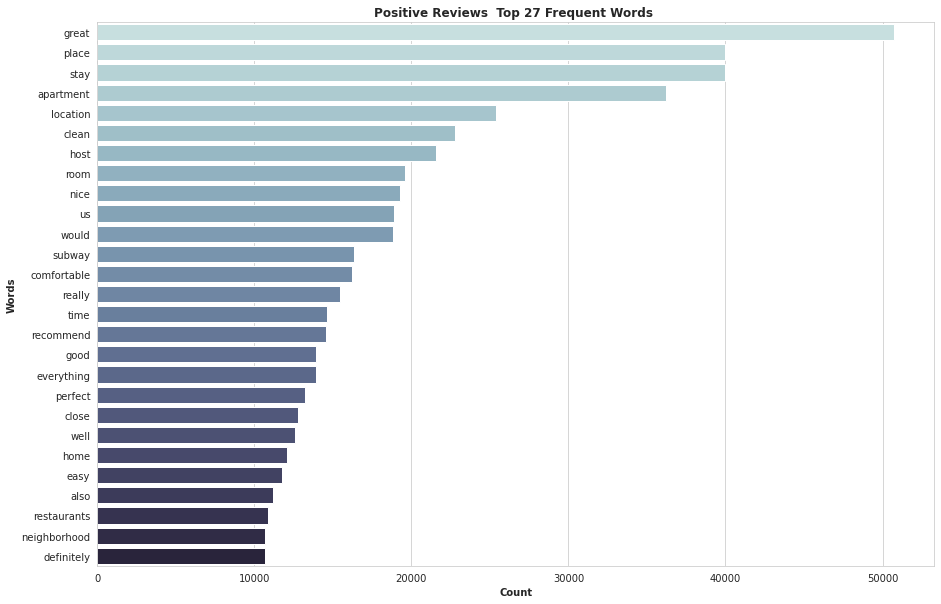

In [233]:
plt.figure(figsize=(15,10))
sns.barplot(y="word", x="count", data=top_27_pos, palette="ch:start=.2,rot=-.3")
plt.title('Positive Reviews  Top 27 Frequent Words ',fontweight="bold" )
plt.xlabel('Count', fontweight="bold")
plt.ylabel('Words', fontweight="bold")
plt.show()


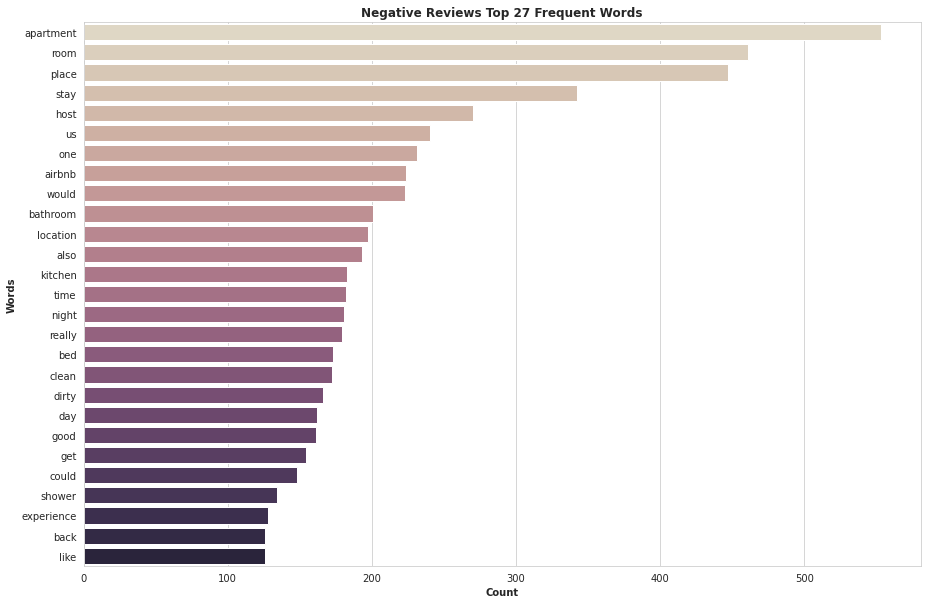

In [228]:
plt.figure(figsize=(15,10))
sns.barplot(y="word", x="count", data=top_27_neg, palette="ch:s=-.2,r=.6")
plt.title('Negative Reviews Top 27 Frequent Words',fontweight="bold" )
plt.xlabel('Count', fontweight="bold")
plt.ylabel('Words', fontweight="bold")
plt.show()


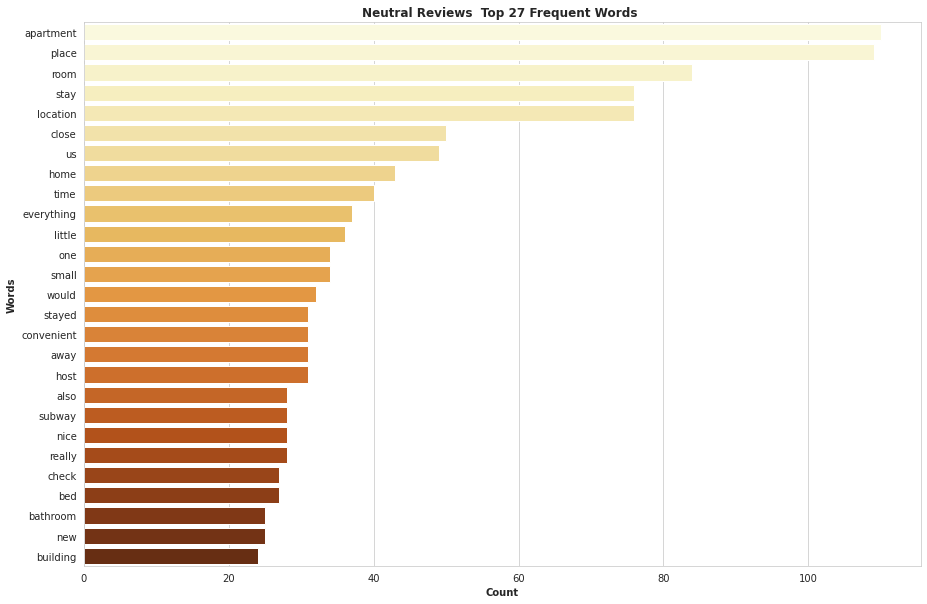

In [231]:
plt.figure(figsize=(15,10))
sns.barplot(y="word", x="count", data=top_27_neut, palette="YlOrBr")
plt.title('Neutral Reviews  Top 27 Frequent Words ',fontweight="bold" )
plt.xlabel('Count', fontweight="bold")
plt.ylabel('Words', fontweight="bold")
plt.show()

In [214]:
pos_reviews =  ''.join(pos_reviews['comments'])
neg_reviews =  ''.join(neg_reviews['comments'])
neut_reviews =  ''.join(neut_reviews['comments'])

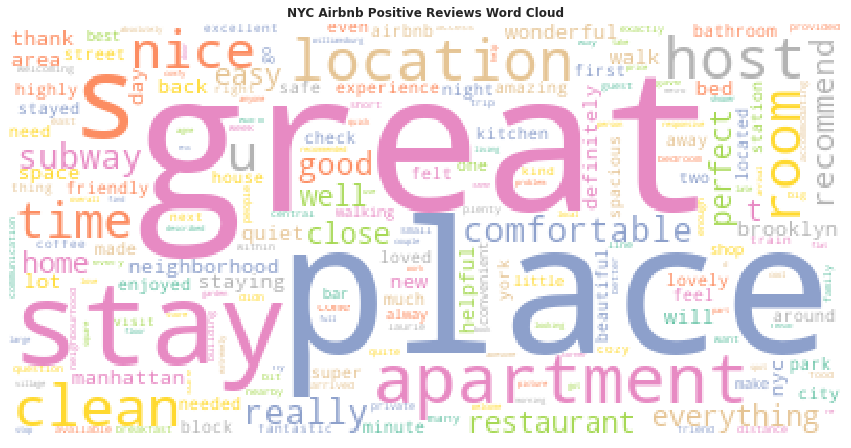

In [161]:
# Plot wordcloud of positive comments
pos_wordcloud = WordCloud(stopwords=set(STOPWORDS), colormap='Set2',collocations=False, mode="RGBA", background_color="white").generate(pos_reviews)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(pos_wordcloud, interpolation="None")
plt.title('NYC Airbnb Positive Reviews Word Cloud', fontweight="bold")
plt.show();

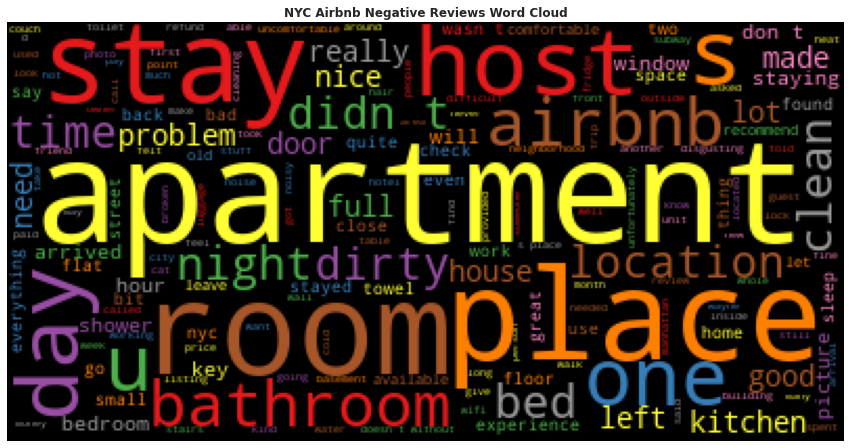

In [165]:
# Plot wordcloud of negative comments
neg_wordcloud = WordCloud(stopwords=set(STOPWORDS),repeat=False, colormap='Set1', background_color="black").generate(neg_reviews)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(neg_wordcloud)
plt.title('NYC Airbnb Negative Reviews Word Cloud', fontweight="bold")
plt.show();

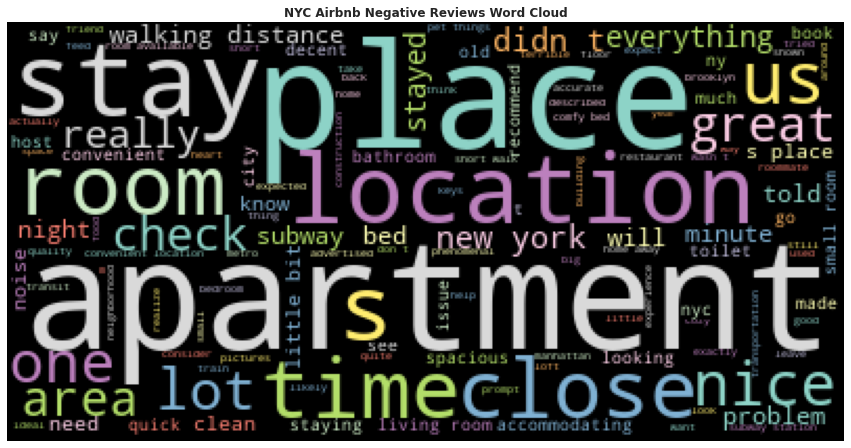

In [219]:
# Plot wordcloud of neutral comments
neg_wordcloud = WordCloud(stopwords=set(STOPWORDS),repeat=False, colormap='Set3', background_color="black").generate(neut_reviews)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(neg_wordcloud)
plt.title('NYC Airbnb Neutral Reviews Word Cloud', fontweight="bold")
plt.show();

### Explore Polarity Variable and Correlation with Score Features

In [242]:
listings = pd.read_csv('/content/listings.csv');

In [243]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153199 entries, 0 to 153198
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            153199 non-null  int64  
 1   name                          153145 non-null  object 
 2   host_name                     152962 non-null  object 
 3   neighbourhood_cleansed        153199 non-null  object 
 4   neighbourhood_group_cleansed  153199 non-null  object 
 5   latitude                      153199 non-null  float64
 6   longitude                     153199 non-null  float64
 7   price                         153199 non-null  float64
 8   review_scores_rating          118410 non-null  float64
 9   review_scores_accuracy        116347 non-null  float64
 10  review_scores_cleanliness     116388 non-null  float64
 11  review_scores_checkin         116327 non-null  float64
 12  review_scores_communication   116365 non-nul

In [244]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70811 entries, 0 to 71635
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      70811 non-null  int64  
 1   id              70811 non-null  int64  
 2   reviewer_id     70811 non-null  int64  
 3   reviewer_name   70811 non-null  object 
 4   comments        70811 non-null  object 
 5   month           70811 non-null  object 
 6   weekday         70811 non-null  object 
 7   language        70811 non-null  object 
 8   text_length     70811 non-null  int64  
 9   polarity_score  70811 non-null  float64
 10  sentiment_type  70811 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 6.5+ MB


In [245]:
df_polarity = pd.DataFrame(df_reviews.groupby(['listing_id']).mean()['polarity_score'])


In [246]:
df_polarity.reset_index()

,listing_id,polarity_score
0,2539,0.804388
1,2595,0.806344
2,3831,0.801400
3,5121,0.884436
4,5136,0.986911
...,...,...
255,150804,0.948765
256,150989,0.960839
257,151199,0.894280
258,152263,0.880202


In [247]:
listing_polar= pd.merge(listings, df_polarity, left_on='id', right_on='listing_id', how='inner')

In [248]:
listing_polar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            931 non-null    int64  
 1   name                          931 non-null    object 
 2   host_name                     931 non-null    object 
 3   neighbourhood_cleansed        931 non-null    object 
 4   neighbourhood_group_cleansed  931 non-null    object 
 5   latitude                      931 non-null    float64
 6   longitude                     931 non-null    float64
 7   price                         931 non-null    float64
 8   review_scores_rating          928 non-null    float64
 9   review_scores_accuracy        927 non-null    float64
 10  review_scores_cleanliness     927 non-null    float64
 11  review_scores_checkin         927 non-null    float64
 12  review_scores_communication   927 non-null    float64
 13  revie

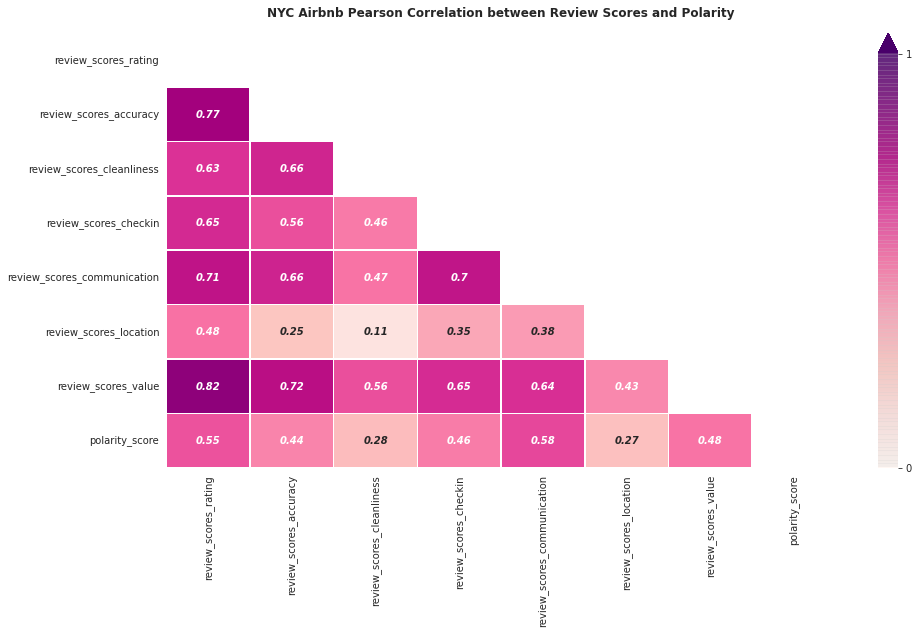

In [250]:
# Setup figure size and style
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'polarity_score']

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(listing_polar[review_scores].corr(), dtype=np.bool))
df_heatmap = sns.heatmap(abs(listing_polar[review_scores].corr()), mask=mask, vmin=0, vmax=1, annot=True, cmap='RdPu', linewidth=0.5,
                        cbar_kws={'orientation':'vertical', 'shrink':1,'extend':'max', 'ticks':[1, 0], 'drawedges':True},
                        annot_kws={'fontsize':10, 'fontstyle':'italic','fontweight':'bold', 'verticalalignment':'center'})
df_heatmap.set_title('NYC Airbnb Pearson Correlation between Review Scores and Polarity', fontdict={'fontsize':12}, pad=16, fontweight="bold")
plt.show();
# Save output image as .png
#plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

In [255]:
df_reviews.columns

Index(['listing_id', 'id', 'reviewer_id', 'reviewer_name', 'comments', 'month',
       'weekday', 'language', 'text_length', 'polarity_score',
       'sentiment_type'],
      dtype='object')

In [261]:
df_reviews.drop(columns=['id', 'reviewer_name', 'comments', 'month',
       'weekday', 'language', 'text_length',])

,listing_id,reviewer_id,polarity_score,sentiment_type
0,2595,38960,0.9274,Positive
1,2595,71130,0.9136,Positive
2,2595,117113,0.9409,Positive
3,2595,1783688,0.9863,Positive
4,2595,1870771,0.9542,Positive
...,...,...,...,...
71631,72265,109542482,0.7774,Positive
71632,72265,1282541,0.6249,Positive
71633,72265,8936723,0.9870,Positive
71634,72265,17160406,0.8126,Positive


In [273]:
df_reviews.sentiment_type.value_counts()

Positive    69630
Negative      708
Neutral       473
Name: sentiment_type, dtype: int64

In [274]:
df_reviews.to_csv('reviews_polarity.csv', index=False)